In [27]:
%pylab inline 
%load_ext autoreload
%autoreload 2
import pickle
import numpy as np
# import jax
# import jax_cosmo as jc
# import jax.numpy as np
from DifferentiableHOS.Plot import plot_contours
#cosmo_jax = jc.Planck15()

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/dl264294/.conda/envs/env_nbody/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['cov']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
results_dict = pickle.load( open( "/Users/dl264294/Desktop/github/DifferentiableHOS/scripts/results.pkl", "rb" ) )

In [3]:
ell=results_dict['ell']
jac=results_dict['jac']
ps=results_dict['ps']

/Users/dl264294/.local/lib/python3.8/site-packages/jax/_src/lax/lax.py:6081: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


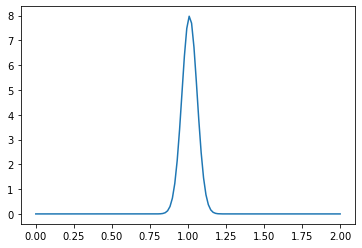

In [28]:
z = linspace(0,2,100)
pz = zeros_like(z)
pz[50] =1. 
nzs_s=jc.redshift.kde_nz(z, pz, bw=0.05)
# let's draw the nz on a new array of redshifts
zsamp = np.linspace(0,2,128)
plot(zsamp, nzs_s(zsamp))
nzs = [nzs_s]
probes = [ jc.probes.WeakLensing(nzs, sigma_e=0.26) ]
cls = jc.angular_cl.angular_cl(cosmo_jax, ell, probes)


# we compute the covariance matrix using the tools from the Jax module
mu, cov = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo_jax, ell, probes,f_sky=25/41252, sparse=True);

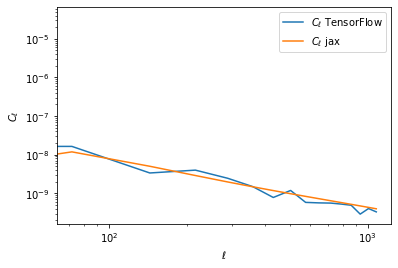

In [29]:
#We compare the theoretical power spectrum with the power spectrum obtained from a single simulation
loglog(ell,  ps, label='$C_{\ell}$ TensorFlow')
loglog(ell, mu, label='$C_{\ell}$ jax')
xlabel('$\ell$')
ylabel('$C_{\ell}$')
legend()

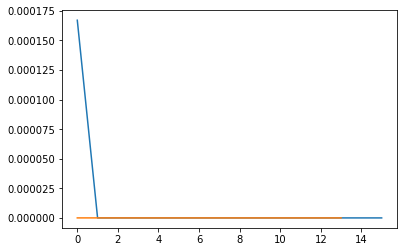

In [54]:
# We compare the Jax and the TensorFlow Jacobian for both the cosmological parameters
plot(jac[:,0])
plot(dmu[:, 0])

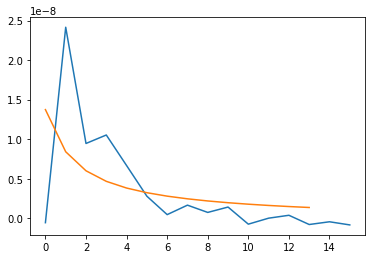

In [55]:

plot(jac[:,1])
plot(dmu[:, 1])

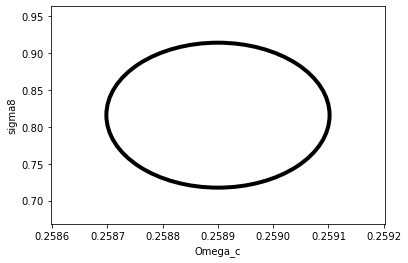

In [31]:
# Now we can compose the Fisher matrix:
params=np.array([0.2589,0.8159]) 
F_2 = jc.sparse.dot(jac.T, jc.sparse.inv(cov), jac)
plot_contours(F_2, params, fill=False,color='black',lw=4);
xlabel('Omega_c')
ylabel('sigma8');

In [32]:
#Here we calculate the mean between 10 independent simulations
ps_array=[]
jac_array=[]
for i in (range(10)):
    results_dict = pickle.load( open( "/Users/dl264294/Desktop/github/DifferentiableHOS/scripts/results"+str(i)+".pkl", "rb" ) )
    ps=results_dict['ps']
    jac=results_dict['jac']
    ps_array.append(ps)
    jac_array.append(jac)

In [49]:
ps_mean=np.mean(np.stack(ps_array),axis=0)
jac_mean=np.mean(np.stack(jac_array),axis=0)

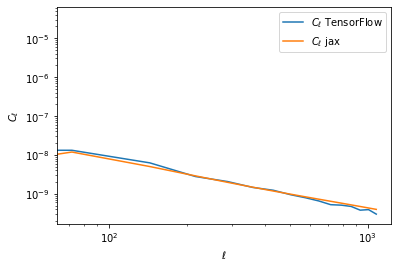

In [35]:
#We compare the theoretical power spectrum with the mean power spectrum obtained from 10 simulations
loglog(ell,  ps_mean, label='$C_{\ell}$ TensorFlow')
loglog(ell, mu, label='$C_{\ell}$ jax')
xlabel('$\ell$')
ylabel('$C_{\ell}$')
legend()

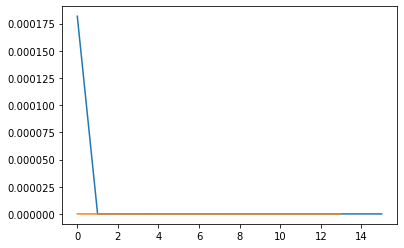

In [52]:
# We compare the Jax and the mean TensorFlow Jacobian for both the cosmological parameters 
plot(jac_mean[:,0])
plot(dmu[:, 0])

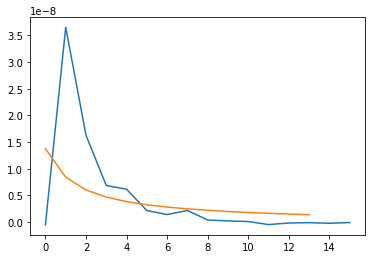

In [53]:
plot(jac_mean[:,1])
plot(dmu[:, 1])

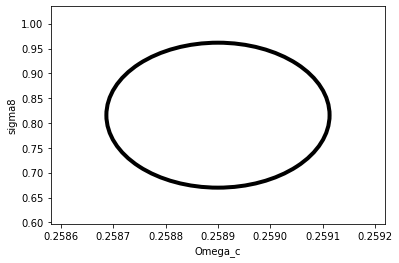

In [36]:
#Fisher Matrix
F_3 = jc.sparse.dot(jac_mean.T, jc.sparse.inv(cov), jac_mean)
plot_contours(F_3, params, fill=False,color='black',lw=4);
xlabel('Omega_c')
ylabel('sigma8');

In [37]:
# We esclude the 2 largest scales 
jac_mean2=jac_mean[2:]
cls2 = jc.angular_cl.angular_cl(cosmo_jax, ell[2:], probes)
mu2, cov2 = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo_jax, ell[2:], probes,f_sky=25/41252, sparse=True);

/Users/dl264294/.local/lib/python3.8/site-packages/jax/_src/lax/lax.py:6081: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


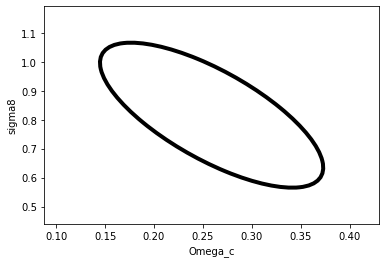

In [39]:
F_4 = jc.sparse.dot(jac_mean2.T, jc.sparse.inv(cov2), jac_mean2)
plot_contours(F_4, params, fill=False,color='black',lw=4);
xlabel('Omega_c')
ylabel('sigma8');

In [41]:
def mean_fn(p):
  cosmo = jc.Planck15(Omega_c=p[0], sigma8=p[1])
  # Compute signal vector
  m = jc.angular_cl.angular_cl(cosmo, ell[2:], probes)
  return m.flatten()
jac_mean = jax.jit(jax.jacfwd(mean_fn))
dmu = jac_mean(params)

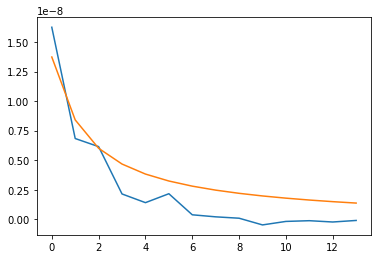

In [46]:
plot(jac_mean2[:,1])
plot(dmu[:, 1])

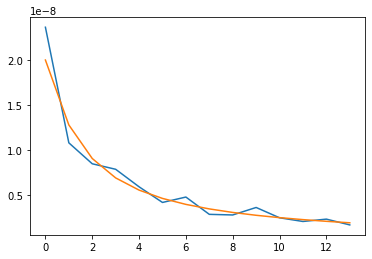

In [47]:
plot(jac_mean2[:,0])
plot(dmu[:, 0])